# Grover's Algorithm with Noise

In [2]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.aer import QasmSimulator

# using IBM's hardware
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram

# import qutip
from qutip import *

# basic packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

# Import Qiskit Ignis error correction tools
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

# IBM Q Experience: 951cc4a6b66ecf58c9635d36684745f41d445e910b3ec7ce94f52a9a136e027b9ec14a012bd5b6b7b9c86a36f20fb415c08618c442a7d9339fb7c6acbb809c42

In [3]:
# Token for IBM hardware
token = "951cc4a6b66ecf58c9635d36684745f41d445e910b3ec7ce94f52a9a136e027b9ec14a012bd5b6b7b9c86a36f20fb415c08618c442a7d9339fb7c6acbb809c42"
IBMQ.save_account(token, overwrite=True)

# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
device = provider.get_backend('ibmq_16_melbourne')

## Grover Circuit for |11>

### Design oracle to flip the sign on |11> 

In [4]:
n = 2
init = tensor(snot()*basis(2,0),snot()*basis(2,0))
psi1 = tensor(qeye(n),snot())*init
psi2 = cnot()*psi1
psi3 = tensor(qeye(n),snot())*psi2
print(init)
print(psi3)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.5]
 [0.5]
 [0.5]
 [0.5]]
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.5]
 [ 0.5]
 [ 0.5]
 [-0.5]]


### Implement circuit with oracle and Grover diffusion operator

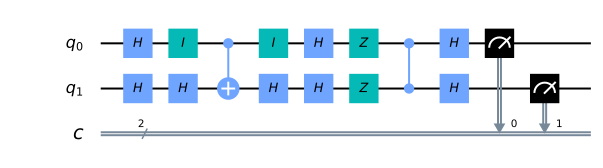

In [5]:
# Initialize quantum circuit with 2 bits
n = 2
grover_circuit = QuantumCircuit(n,n)

# Superposition
for qubit in range(n):
    grover_circuit.h(qubit)
    
# Oracle Uf (sign flip |11>)
grover_circuit.h(1)
grover_circuit.i(0)
grover_circuit.cx(0,1)
grover_circuit.h(1)
grover_circuit.i(0)

# Reflection Us 
for qubit in range(n):
    grover_circuit.h(qubit)
for qubit in range(n):
    grover_circuit.z(qubit)
grover_circuit.cz(0,1)
for qubit in range(n):
    grover_circuit.h(qubit)
    
# Measure
grover_circuit.measure(grover_circuit.qregs[0],grover_circuit.cregs[0])

# draw circuit
%matplotlib inline
grover_circuit.draw('mpl')


### Simulate circuit on 'statevector_simulator' to obtain statevector output

In [6]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(grover_circuit, backend_sim)
final_state = job_sim.result().get_statevector()
print(final_state)

[0.+0.0000000e+00j 0.+0.0000000e+00j 0.+0.0000000e+00j 1.-3.6739404e-16j]


### Simulate circuit on 'qasm_simulator' to obtain results for 1024 shots

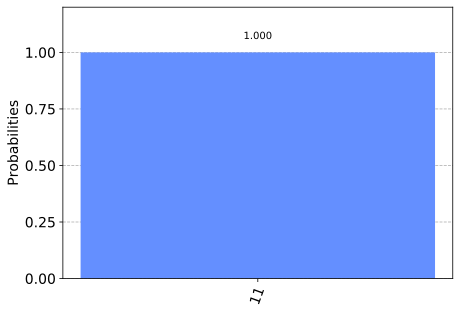

In [7]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

### Now, we add noise

### Create a noise model that causes qubit gate errors at z gates 

In [8]:
def z_noise(p_gate):
    error_gate1 = depolarizing_error(p_gate, 1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, ["z"]) # single qubit gate error is applied to z gates. 
                                                                # z gate is used in grover diffusion operator on each qubit
    return noise_model

### Running the circuit with the noise model and extract the counts

In [9]:
noise = 0.1
noise_model = z_noise(noise)

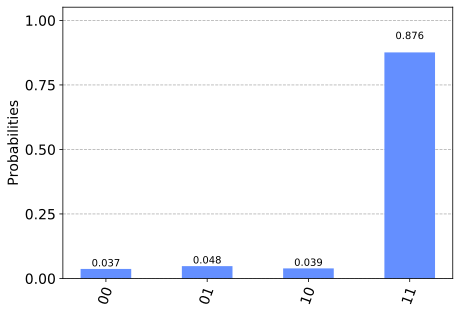

In [10]:
noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
%matplotlib inline
plot_histogram(noisy_counts)

### Show outputs across a range of noise levels

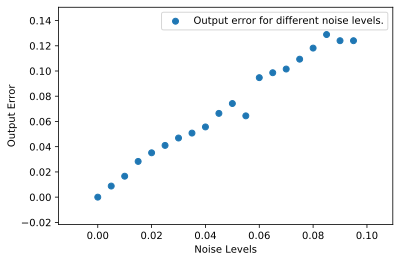

In [13]:
n = 20
ind = 0
noise_range = [i * 0.005 for i in range(n)]
output_error = []
for noise in noise_range:
    noise_model = z_noise(noise)
    noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    output_error.append(1.-noisy_counts['11'] / (sum(noisy_counts.values())))
    
ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
ax.scatter(noise_range, output_error, label="Output error for different noise levels.")
plt.legend()
plt.show()

### Running the circuit on IBM's hardware

In [84]:
# Running circuit on IBM hardware
job = execute(grover_circuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


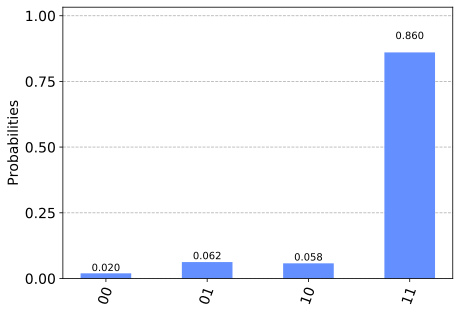

In [85]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

### Applying Error Correction Schemes

In [86]:
n = 2
r = 3
cq = QuantumRegister(n*r,'code\ qubit\ ')
mb = ClassicalRegister(n,'measurement\ bit\ ')

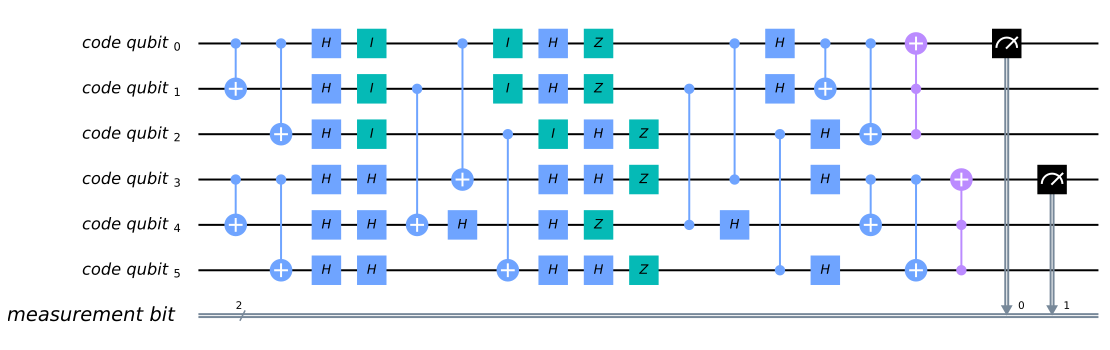

In [15]:
# Repetitive Code
qc_encode = QuantumCircuit(cq, mb)
qc_encode.cx(cq[0],cq[1])
qc_encode.cx(cq[0],cq[2])
qc_encode.cx(cq[3],cq[4])
qc_encode.cx(cq[3],cq[5])

# Grover's Algorithm
grover_intermediate = QuantumCircuit(cq, mb)
for qubit in range(n*r):
    grover_intermediate.h(qubit)
for qubit in range(r):
    grover_intermediate.i(qubit)
    grover_intermediate.h(qubit+3)
for qubit in range(r):
    grover_intermediate.cx(qubit,qubit+3)
for qubit in range(r):
    grover_intermediate.i(qubit)
    grover_intermediate.h(qubit+3)
for qubit in range(n*r):
    grover_intermediate.h(qubit)
for qubit in range(n*r):
    grover_intermediate.z(qubit)
for qubit in range(r):
    grover_intermediate.cz(qubit,qubit+3)
for qubit in range(n*r):
    grover_intermediate.h(qubit)

# Decode Repetitive Code
qc_decode = QuantumCircuit(cq, mb)
qc_decode.cx(cq[0],cq[1])
qc_decode.cx(cq[0],cq[2])
qc_decode.toffoli(cq[2],cq[1],cq[0])
qc_decode.cx(cq[3],cq[4])
qc_decode.cx(cq[3],cq[5])
qc_decode.toffoli(cq[5],cq[4],cq[3])

qc_measure = QuantumCircuit(cq, mb)
qc_measure.measure(cq[0],mb[0])
qc_measure.measure(cq[3],mb[1])

rep_circuit = qc_encode+grover_intermediate+qc_decode+qc_measure
%matplotlib inline
rep_circuit.draw(output='mpl')

### Simulate without noise

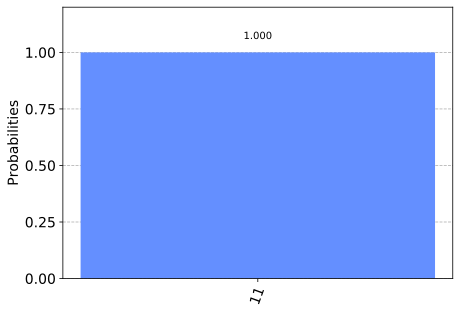

In [16]:
job = execute(rep_circuit, Aer.get_backend('qasm_simulator'), noise_model=None, shots=10000 )
results = job.result().get_counts()
plot_histogram(results)

### Simulate with noise

In [28]:
noise = 0.1
noise_model = z_noise(noise)

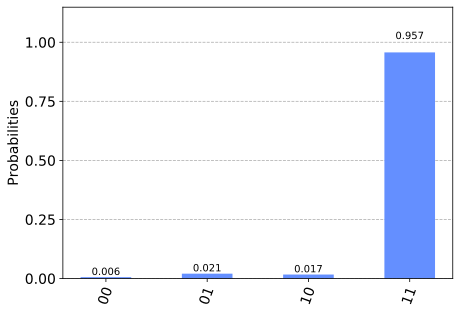

In [29]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(rep_circuit, backend=backend, noise_model=noise_model, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

### Plot of noise errors with and without error correction codes

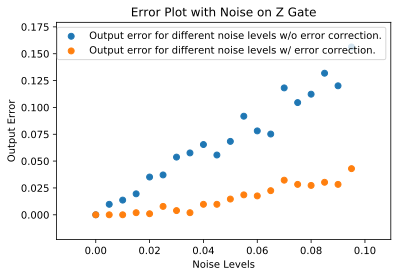

In [37]:
# Show n = 20 vs n = 100 --> increasing the noise
n = 20
ind = 0
noise_range = [i * 0.005 for i in range(n)]
output_error = []
rep_output_error = []
for noise in noise_range:
    noise_model = z_noise(noise)
    noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    output_error.append(1.-noisy_counts['11'] / (sum(noisy_counts.values())))
    
    rep_noisy_counts = execute(rep_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    rep_output_error.append(1.-rep_noisy_counts['11'] / (sum(rep_noisy_counts.values())))
    
ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
plt.title('Error Plot with Noise on Z Gate')
ax.scatter(noise_range, output_error, label="Output error for different noise levels w/o error correction.")
ax.scatter(noise_range, rep_output_error, label="Output error for different noise levels w/ error correction.")
plt.legend()
plt.show()

### Let's add noise on all the gates (but not on measurements)

In [31]:
def gate_noise(p_gate):
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"])  # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_gate1, ["z"])  # single qubit gate error is applied to z gates.
    noise_model.add_all_qubit_quantum_error(error_gate1, ["h"])  # single qubit gate error is applied to z gates.
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cz"]) # two qubit gate error is applied to cz gates                                                            
#     error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
#     noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    return noise_model

In [32]:
noise = 0.05
noise_model = gate_noise(noise)

#### Simulate noisy gate circuit with original Grover's Circuit

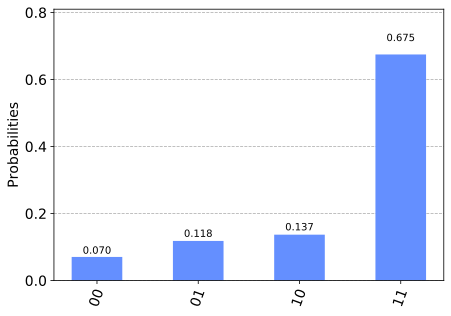

In [33]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, noise_model=noise_model, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

#### Simulate noisy gate circuit with Grover's circuit with repetition code

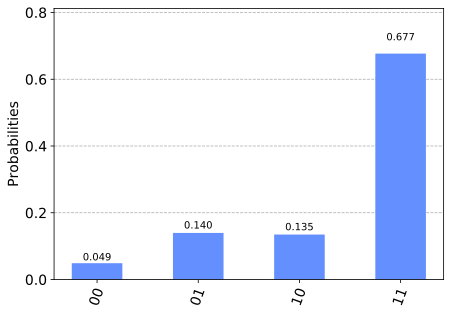

In [34]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(rep_circuit, backend=backend, noise_model=noise_model, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

#### Plot for a range of noise levels

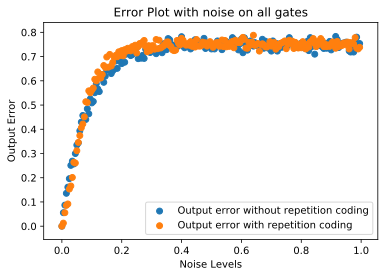

In [36]:
n = 200
ind = 0
noise_range = [i * 0.005 for i in range(n)]
orig_output_error = []
rep_output_error = []
for noise in noise_range:
    noise_model = gate_noise(noise)
    orig_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    rep_counts = execute(rep_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    orig_output_error.append(1.-orig_counts['11'] / (sum(orig_counts.values())))
    rep_output_error.append(1.-rep_counts['11'] / (sum(rep_counts.values())))
    
ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
plt.title('Error Plot with Noise on All Gates')
ax.scatter(noise_range, orig_output_error, label="Output error without repetition coding")
ax.scatter(noise_range, rep_output_error, label="Output error with repetition coding")
plt.legend()
plt.show()

# &nbsp;
# &nbsp;
# &nbsp;
# &nbsp;
## -------------------------------------------------------------------------------------------------------
## Grover Circuit for |01>

### First, let's make sure that the oracle gives us the ouput we want

In [32]:
# Test that the oracle flips the sign on |01> 
n = 2
init = tensor(snot()*basis(2,0),snot()*basis(2,0))
psi1 = tensor(sigmax(),snot())*init
psi2 = cnot()*psi1
psi3 = tensor(sigmax(),snot())*psi2
print(init)
print(psi3)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.5]
 [0.5]
 [0.5]
 [0.5]]
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.5]
 [-0.5]
 [ 0.5]
 [ 0.5]]


/Users/chanc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chanc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  after removing the cwd from sys.path.
/Users/chanc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import th

### Building the circuit

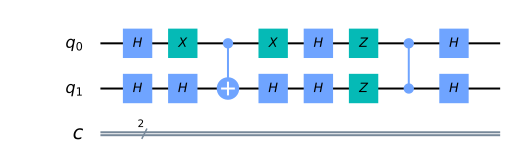

In [40]:
# Initialize quantum circuit with 2 qubits
n = 2
grover_circuit = QuantumCircuit(n,n)

# Superposition
for qubit in range(n):
    grover_circuit.h(qubit)
    
# Oracle Uf (flips sign of |01>) 
# Note: The order of the tensor product in QuantumCircuit is [a00, a10, a01, a11], where the first number is
# the least significant qubit. This is different from qutip, which is ordered [a00, a01, a10, a11]
grover_circuit.h(1)
grover_circuit.x(0)
grover_circuit.cx(0,1)
grover_circuit.h(1)
grover_circuit.x(0)

# Reflection Us 
for qubit in range(n):
    grover_circuit.h(qubit)
for qubit in range(n):
    grover_circuit.z(qubit)
grover_circuit.cz(0,1)
for qubit in range(n):
    grover_circuit.h(qubit)

# draw circuit
%matplotlib inline
grover_circuit.draw('mpl')

### Simulate circuit on 'statevector_simulator' to obtain statevector output

In [41]:
# Run Grover's
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(grover_circuit, backend_sim)
final_state = job_sim.result().get_statevector()
print(final_state)

[ 1.11022302e-16+6.12323400e-17j -3.92523115e-17+4.93038066e-32j
  1.00000000e+00-3.67394040e-16j -3.92523115e-17+1.83697020e-16j]


### Simulate circuit on 'qasm_simulator' to obtain results for 1024 shots

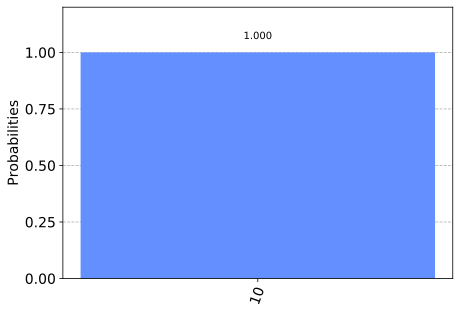

In [42]:
grover_circuit.measure(grover_circuit.qregs[0],grover_circuit.cregs[0])
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

### Now, we add noise

### Running the circuit with the same noise model as before and extract the counts

In [43]:
noise = 0.1
noise_model = z_noise(noise)

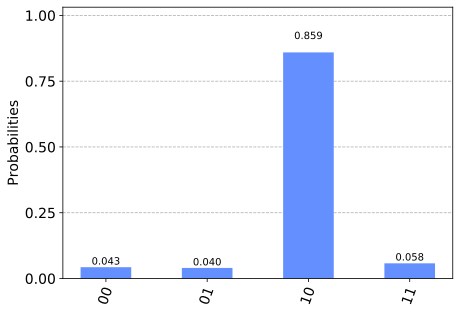

In [44]:
noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(noisy_counts)

### Show outputs across a range of noise levels

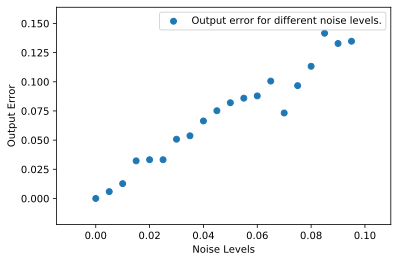

In [47]:
n = 20
ind = 0
noise_range = [i * 0.005 for i in range(n)]
output_error = []
for noise in noise_range:
    noise_model = z_noise(noise)
    noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    output_error.append(1.-noisy_counts['10'] / (sum(noisy_counts.values())))
    
ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
ax.scatter(noise_range, output_error, label="Output error for different noise levels.")
plt.legend()
plt.show()

### Running the circuit on IBM's hardware

In [39]:
# Running circuit on IBM hardware
job = execute(grover_circuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


In [48]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

QiskitError: 'Data for experiment "circuit1740" could not be found.'

### Applying Error Correction Schemes

In [49]:
n = 2
r = 3
cq = QuantumRegister(n*r,'code\ qubit\ ')
mb = ClassicalRegister(n,'measurement\ bit\ ')

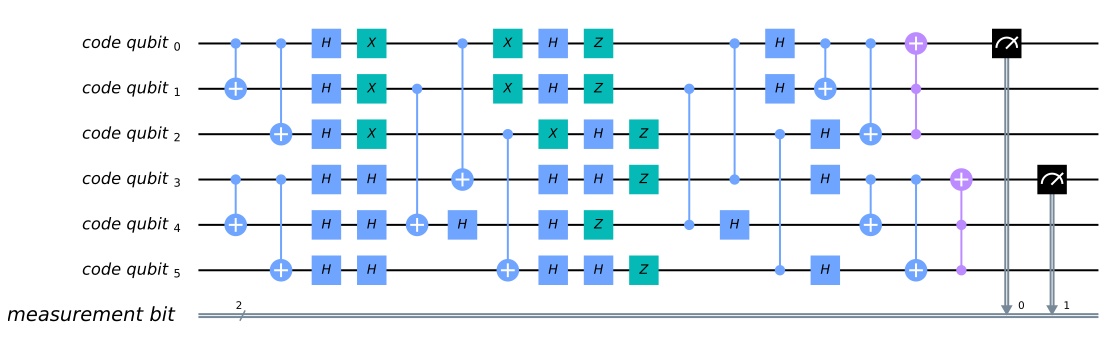

In [50]:
# Repetitive Code
qc_encode = QuantumCircuit(cq, mb)
qc_encode.cx(cq[0],cq[1])
qc_encode.cx(cq[0],cq[2])
qc_encode.cx(cq[3],cq[4])
qc_encode.cx(cq[3],cq[5])

# Grover's Algorithm
grover_intermediate = QuantumCircuit(cq, mb)
for qubit in range(n*r):
    grover_intermediate.h(qubit)
for qubit in range(r):
    grover_intermediate.x(qubit)
    grover_intermediate.h(qubit+3)
for qubit in range(r):
    grover_intermediate.cx(qubit,qubit+3)
for qubit in range(r):
    grover_intermediate.x(qubit)
    grover_intermediate.h(qubit+3)
for qubit in range(n*r):
    grover_intermediate.h(qubit)
for qubit in range(n*r):
    grover_intermediate.z(qubit)
for qubit in range(r):
    grover_intermediate.cz(qubit,qubit+3)
for qubit in range(n*r):
    grover_intermediate.h(qubit)

# Decode Repetitive Code
qc_decode = QuantumCircuit(cq, mb)
qc_decode.cx(cq[0],cq[1])
qc_decode.cx(cq[0],cq[2])
qc_decode.toffoli(cq[2],cq[1],cq[0])
qc_decode.cx(cq[3],cq[4])
qc_decode.cx(cq[3],cq[5])
qc_decode.toffoli(cq[5],cq[4],cq[3])

qc_measure = QuantumCircuit(cq, mb)
qc_measure.measure(cq[0],mb[0])
qc_measure.measure(cq[3],mb[1])

rep_circuit = qc_encode+grover_intermediate+qc_decode+qc_measure
%matplotlib inline
rep_circuit.draw(output='mpl')

### Simulate without noise

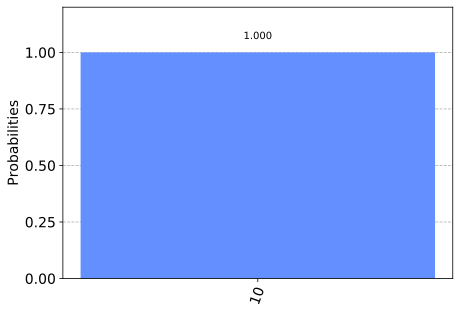

In [51]:
job = execute(rep_circuit, Aer.get_backend('qasm_simulator'), noise_model=None, shots=10000 )
results = job.result().get_counts()
plot_histogram(results)

### Simulate with noise on z gate

In [52]:
noise = 0.1
noise_model = z_noise(noise)

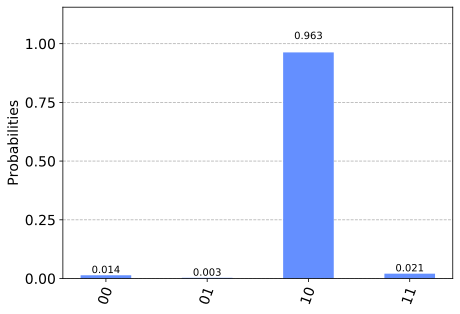

In [53]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(rep_circuit, backend=backend, noise_model=noise_model, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

### Plot of noise errors with and without error correction codes

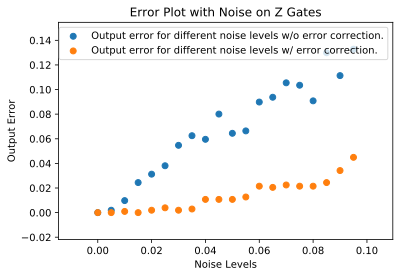

In [55]:
# Show n = 20 vs n = 100 --> increasing the noise
n = 20
ind = 0
noise_range = [i * 0.005 for i in range(n)]
output_error = []
rep_output_error = []
for noise in noise_range:
    noise_model = get_noise(noise,noise)
    noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    output_error.append(1.-noisy_counts['10'] / (sum(noisy_counts.values())))
    
    rep_noisy_counts = execute(rep_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    rep_output_error.append(1.-rep_noisy_counts['10'] / (sum(rep_noisy_counts.values())))
    
ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
plt.title('Error Plot with Noise on Z Gates')
ax.scatter(noise_range, output_error, label="Output error for different noise levels w/o error correction.")
ax.scatter(noise_range, rep_output_error, label="Output error for different noise levels w/ error correction.")
plt.legend()
plt.show()

### Let's add noise on all the gates (but not on measurements)

In [68]:
noise = 0.05
noise_model = gate_noise(noise)

#### Simulate noisy gate circuit with original Grover's Circuit


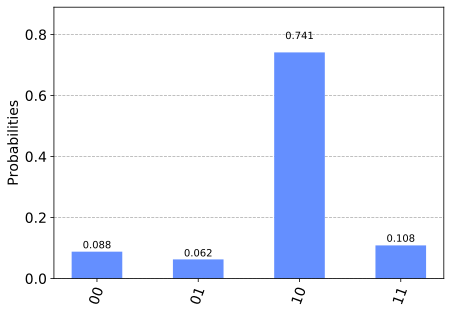

In [69]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, noise_model=noise_model, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

#### Simulate noisy gate circuit with Grover's circuit with repetition code

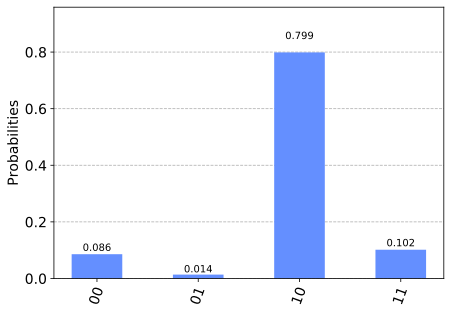

In [70]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(rep_circuit, backend=backend, noise_model=noise_model, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

#### Plot for a range of noise levels

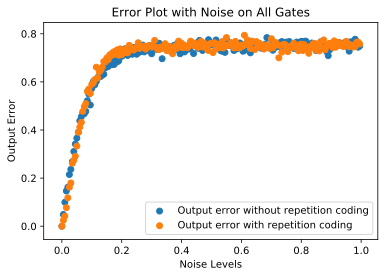

In [71]:
n = 200
ind = 0
noise_range = [i * 0.005 for i in range(n)]
orig_output_error = []
rep_output_error = []
for noise in noise_range:
    noise_model = gate_noise(noise)
    orig_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    rep_counts = execute(rep_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    orig_output_error.append(1.-orig_counts['10'] / (sum(orig_counts.values())))
    rep_output_error.append(1.-rep_counts['10'] / (sum(rep_counts.values())))

ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
plt.title('Error Plot with Noise on All Gates')
ax.scatter(noise_range, orig_output_error, label="Output error without repetition coding")
ax.scatter(noise_range, rep_output_error, label="Output error with repetition coding")
plt.legend()
plt.show()